In [1]:
import numpy as np

import os
import inspect
import sys
import pandas as pd
import charts
import time
import math

from opengrid.library import houseprint

from scipy.signal import butter, lfilter, freqz

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

Server running in the folder /usr/local/opengrid/notebooks/Analysis/Thesis_Max&Jean/Block_detection at 127.0.0.1:58443


In [2]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
34 Sites created
34 Devices created
97 sensors created
Houseprint parsing complete


In [3]:
device = hp.find_device('FL03001441')
device.get_sensors()

[
     Fluksosensor
     Key: 81fb589c911e808daa96a2064bebed41
     Type: electricity
     , 
     Fluksosensor
     Key: 212ce724e124fbde0fb649396375d099
     Type: gas
     , 
     Fluksosensor
     Key: c57f45b21e2ec21ab427f172478e1ca4
     Type: water
     , 
     Fluksosensor
     Key: 156e0abc64b00c5e98dbd3c17883b5f6
     Type: electricity
     , 
     Fluksosensor
     Key: e5306ee3a4235498592fc89ee0ede353
     Type: electricity
     ]

In [98]:
#Get Electricity data
head = pd.Timestamp('2015-12-15 01:00:00')
tail = pd.Timestamp('2015-12-16 01:00:00')
electr = hp.find_sensor('81fb589c911e808daa96a2064bebed41')
df_el = electr.get_data(head,tail,diff=True, unit='W')
df_el = df_el.dropna()

In [16]:
#Get Gas data
head = pd.Timestamp('2015-11-14 01:00:00')
tail = pd.Timestamp('2015-11-15 01:00:00')
electr = hp.find_sensor('212ce724e124fbde0fb649396375d099')
df_el = electr.get_data(head,tail,diff=True, unit='W')
df_el = df_el.dropna()

In [65]:
charts.plot(df_el, show="inline", stock=True)

In [6]:
def znormalization(ts):
    """
    ts - each column of ts is a time series (np.ndarray)
    """
    mus = ts.mean(axis = 0)
    stds = ts.std(axis = 0)
    return (ts - mus) / stds

In [7]:
def paa_transform(ts, n_pieces):
    """
    ts: the columns of which are time series represented by e.g. np.array
    n_pieces: M equally sized piecies into which the original ts is splitted
    """
    splitted = np.array_split(ts, n_pieces) ## along columns as we want
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [8]:
def sax_transform(ts, n_pieces, alphabet):
    """
    ts: columns of which are time serieses represented by np.array
    n_pieces: number of segments in paa transformation
    alphabet: the letters to be translated to, e.g. "abcd", "ab"
    return np.array of ts's sax transformation
    Steps:
    1. znormalize
    2. ppa
    3. find norm distribution breakpoints by scipy.stats
    4. convert ppa transformation into strings
    """
    from scipy.stats import norm
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    paa_ts = paa_transform(znormalization(ts), n_pieces)
    return np.apply_along_axis(translate, 0, paa_ts)

In [9]:
def makeArray(array1):
    arrayValues=[]    
    for i in range(0, array1.size-1):
        if(i<array1.size):
             arrayValues.append(ord(array1.iloc[i])-97)
    df=pd.DataFrame(arrayValues)
    return df

In [178]:
def find_blocks(df_parent, row_parent, blocks, df_original, first_time = True):
    min_lvl = 0
    start = False
    
    block_start = 0
    block_end = 0
    
    nr_of_blocks_start = blocks.size
    
    nested = row_parent
    
    if first_time:
        start = True
        min_lvl = df_parent['repeatedValues'].min()
        
    #append last value again
    post_index = df_parent.index[-1] + pd.Timedelta(minutes=1)

    temp = pd.DataFrame(data=[df_parent.iloc[-1]], index=[post_index], columns=['repeatedValues'])
    df_parent = df_parent.append(temp)

    df_parent.sort_index(inplace=True)

    for i in range(1, df_parent.size - 1):
        if start == False and df_parent['repeatedValues'].iloc[i - 1] - df_parent['repeatedValues'].iloc[i] == 0:
            min_lvl = df_parent['repeatedValues'].iloc[i]
            start = True
        
        if start == True and df_parent['repeatedValues'].iloc[i] > min_lvl and df_parent['repeatedValues'].iloc[i - 1] == min_lvl:
            block_start = df_parent.index[i - 1]
            
        if start == True and block_start != 0 and df_parent['repeatedValues'].iloc[i] <= min_lvl:
            block_end = df_parent.index[i]
            
            #Match if the length is more than 10% less than the parent
            temp = pd.DataFrame(data=[[str(block_start), str(block_end), nested]], columns=['start', 'stop', 'nested_in'])
            
            if float(df_parent.index.size - df_parent.ix[block_start : block_end].index.size) / float(df_parent.index.size) > 0.10:
                blocks = blocks.append(temp)
            
            df_parent2 = df_original.ix[block_start : block_end]
            row_parent = blocks.index.size - 1
            blocks = find_blocks(df_parent2, row_parent, blocks, df_original, False)
            
            block_start = 0
            block_end = 0
            
        if start == True and block_start == 0 and df_parent['repeatedValues'].iloc[i] < min_lvl:
            #Lvl dropped below min value so the min value was not assigned properly
            if df_parent['repeatedValues'].iloc[i+1] >= df_parent['repeatedValues'].iloc[i]:
                
                #Match if the length is more than 10% less than the parent
                temp = pd.DataFrame(data=[[str(df_parent.index[0]), str(df_parent.index[i]), nested]], columns=['start', 'stop', 'nested_in'])
                
                if float(df_parent.index.size - df_parent.ix[df_parent.index[0] : df_parent.index[i]].index.size) / float(df_parent.index.size) > 0.10:
                    blocks = blocks.append(temp)
                
                min_lvl = df_parent['repeatedValues'].iloc[i]
                
    
    return blocks

In [179]:
def blockdetection(dataframe):
    
    #Take the rolling mean to filter out peaks
    df_rm = dataframe.rolling(window=6,center=False).median()
    df_rm.index = df_rm.index - pd.Timedelta(minutes=3)
    df_rm = df_rm.dropna()
    
    #Z normalize
    zScoresOriginalGraph=znormalization(df_rm)
    
    #Paa transform
    splitData = paa_transform(zScoresOriginalGraph, df_rm.size/3) #size of df devided by 3 (if 3 in next line remains)
    splitData_ext = np.repeat(splitData,3,axis = 0)
    
    #make sure the dataframes are of the same length to join the data and the index
    shortage = df_rm.size - splitData_ext.size
    if shortage > 0:
        splitData_ext = np.append(splitData_ext, [splitData_ext[-1]]*shortage)

    elif shortage < 0:
        splitData_ext = splitData_ext[:abs(shortage)-1]

    shortage = df_rm.size - splitData_ext.size
    
    df_paa = pd.DataFrame(index=df_rm.index, data=splitData_ext)
    
    #saxtransform
    saxTransmation = sax_transform(df_paa, df_rm.size/3, "abcdefghijklmnop")
    
    #Revert the letters to numbers
    letters=pd.DataFrame(saxTransmation)
    letters.columns=['col1']
    lettersToNumSax=makeArray(letters.col1) #Expects a pandaframe

    repeatedValues=np.repeat(lettersToNumSax.as_matrix(),3) #expects an array
    
    #make sure the dataframes are of the same length to join the data and the index
    shortage = df_rm.size - repeatedValues.size
    if shortage > 0:
        repeatedValues = np.append(repeatedValues, [repeatedValues[-1]]*shortage)

    elif shortage < 0:
        repeatedValues = repeatedValues[0:repeatedValues.size + shortage]
    
    shortage = df_rm.size - repeatedValues.size
    
    df_repeatedValues = pd.DataFrame(index=df_rm.index, data= repeatedValues, columns=['repeatedValues'])
    
    #pre- and append a zero to make sure the sample starts and ends with the same value
    for i in range(0, 2):
        pre_index = df_repeatedValues.index[0] - pd.Timedelta(minutes=1)
        post_index = df_repeatedValues.index[-1] + pd.Timedelta(minutes=1)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[pre_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[post_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        df_repeatedValues.sort_index(inplace=True)
    
    #Do the actual searching
    blocks = pd.DataFrame(columns=['start', 'stop', 'nested_in'])
    blocks = find_blocks(df_repeatedValues, -1, blocks, df_repeatedValues)
    
    #plot the dataframe with all the blocks
    fig, ax = plt.subplots()
    ax.plot(df_repeatedValues.index, df_repeatedValues, color='grey')
    #ax.plot(df_repeatedValues.index, df_rm, color='grey')

    colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


    for i in range(0, blocks.index.size):
        ax.axvspan(blocks['start'].iloc[i], blocks['stop'].iloc[i], alpha=0.1, color=colors[3])
        #ax.axvspan(str(pd.Timestamp(blocks['start'].iloc[i]) + pd.Timedelta(minutes=3)), str(pd.Timestamp(blocks['stop'].iloc[i]) + pd.Timedelta(minutes=3)), alpha=0.1, color=colors[3])


    plt.show()
    
    return df_rm, blocks.drop_duplicates(subset=['start', 'stop'], keep= 'first')
    
    

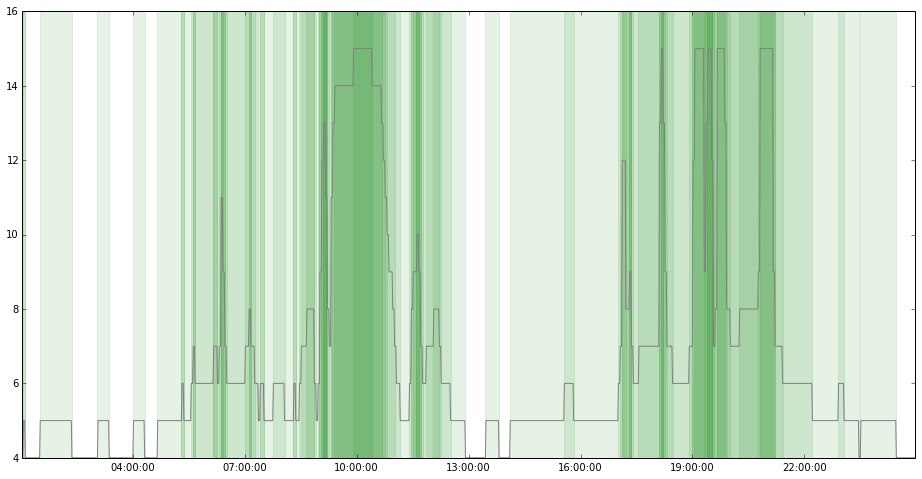

In [180]:
original_rm, blocks = blockdetection(df_el)